In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## WGAN

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
import gzip

In [3]:
PATH = Path('data/comix-gan')
IMG_PATH = PATH/'images/5'
CSV_PATH = PATH/'files.csv'
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [6]:
files = PATH.glob("images/**/*.jpg")
with CSV_PATH.open('w') as fo:
    for f in files: fo.write(f'{f.relative_to(IMG_PATH)},0\n')

In [10]:
class SeparableConv2D(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super(SeparableConv2D, self).__init__()
        self.conv1 = nn.Conv2d(in_chan, in_chan, kernel_size, stride, padding, dilation, groups=in_chan, bias=bias)
        self.pointwise = nn.Conv2d(in_chan, out_chan, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        return self.pointwise(self.conv1(x))

In [11]:
class SeparableConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()
        if pad is None: pad = ks//2//stride
        self.conv = SeparableConv2D(ni, no, kernel_size=ks, stride=stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [12]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nc, ndf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        self.initial = SeparableConvBlock(nc, ndf, 4, 2, bn=False)
        csize,cndf = isize/2,ndf
        self.extra = nn.Sequential(*[SeparableConvBlock(cndf, cndf, 3, 1)
                                    for t in range(n_extra_layers)])

        pyr_layers = []
        while csize > 4:
            pyr_layers.append(SeparableConvBlock(cndf, cndf*2, 4, 2))
            cndf *= 2; csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)

    def forward(self, input):
        x = self.initial(input)
        x = self.extra(x)
        x = self.pyramid(x)
        return self.final(x).mean(0).view(1)

In [13]:
class DeconvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, pad, bn=True):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [14]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize!=isize: cngf*=2; tisize*=2
        layers = [DeconvBlock(nz, cngf, 4, 1, 0)]

        csize, cndf = 4, cngf
        while csize < isize//2:
            layers.append(DeconvBlock(cngf, cngf//2, 4, 2, 1))
            cngf //= 2; csize *= 2

        layers += [DeconvBlock(cngf, cngf, 3, 1, 1) for t in range(n_extra_layers)]
        layers.append(nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        self.features = nn.Sequential(*layers)

    def forward(self, input): return F.tanh(self.features(input))

In [15]:
bs,sz,nz = 64,64,100

In [16]:
tfms = tfms_from_stats(inception_stats, sz)
md = ImageClassifierData.from_csv(PATH, 'images/5', CSV_PATH, tfms=tfms, bs=128,
                                  skip_header=False, continuous=True)

In [17]:
md = md.resize(128)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [18]:
x,_ = next(iter(md.val_dl))

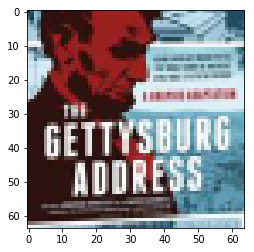

In [19]:
plt.imshow(md.trn_ds.denorm(x)[0]);

In [20]:
netG = DCGAN_G(sz, nz, 3, 64, 1).cuda()
netD = DCGAN_D(sz, 3, 64, 1).cuda()

In [21]:
def create_noise(b): return V(torch.zeros(b, nz, 1, 1).normal_(0, 1))

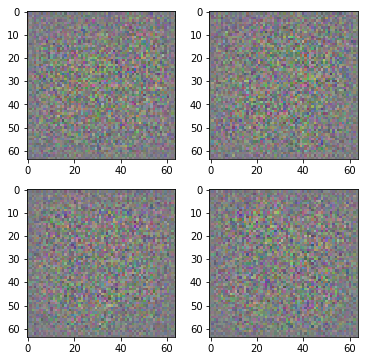

In [22]:
preds = netG(create_noise(4))
pred_ims = md.trn_ds.denorm(preds)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i,ax in enumerate(axes.flat): ax.imshow(pred_ims[i])

In [23]:
def gallery(x, nc=3):
    n,h,w,c = x.shape
    nr = n//nc
    assert n == nr*nc
    return (x.reshape(nr, nc, h, w, c)
              .swapaxes(1,2)
              .reshape(h*nr, w*nc, c))

In [24]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

In [25]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in trange(niter):
        netD.train(); netG.train()
        data_iter = iter(md.trn_dl)
        i,n = 0,len(md.trn_dl)
        with tqdm(total=n) as pbar:
            while i < n:
                set_trainable(netD, True)
                set_trainable(netG, False)
                d_iters = 100 if (first and (gen_iterations < 25) or (gen_iterations % 500 == 0)) else 5
                j = 0
                while (j < d_iters) and (i < n):
                    j += 1; i += 1
                    for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                    real = V(next(data_iter)[0])
                    real_loss = netD(real)
                    fake = netG(create_noise(real.size(0)))
                    fake_loss = netD(V(fake.data))
                    netD.zero_grad()
                    lossD = real_loss-fake_loss
                    lossD.backward()
                    optimizerD.step()
                    pbar.update()

                set_trainable(netD, False)
                set_trainable(netG, True)
                netG.zero_grad()
                lossG = netD(netG(create_noise(bs))).mean(0).view(1)
                lossG.backward()
                optimizerG.step()
                gen_iterations += 1
            
        print(f'Loss_D {to_np(lossD)}; Loss_G {to_np(lossG)}; '
              f'D_real {to_np(real_loss)}; Loss_D_fake {to_np(fake_loss)}')

In [26]:
torch.backends.cudnn.benchmark=True

In [27]:
train(5000, True)

100%|██████████| 8/8 [00:01<00:00,  2.27it/s]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  9.11it/s]s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  9.25it/s]s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  8.99it/s]s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  9.20it/s]s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  9.09it/s]s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  9.06it/s]s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  9.26it/s]s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  8.99it/s]s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  

100%|██████████| 8/8 [00:00<00:00,  6.29it/s]21s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.31it/s]21s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.50it/s]21s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.95it/s]21s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.39it/s]21s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.15it/s]20s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.76it/s]20s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.24it/s]20s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.20it/s]20s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|████████

100%|██████████| 8/8 [00:01<00:00,  4.99it/s]17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.03it/s]17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.06it/s]17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.18it/s]17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.82it/s]17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.55it/s]17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  3.52it/s]17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  2.63it/s]18s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.26it/s]18s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|█████████

100%|██████████| 8/8 [00:01<00:00,  5.08it/s]19s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.06it/s]19s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.16it/s]19s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.50it/s]19s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.45it/s]19s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.37it/s]19s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.38it/s]19s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.49it/s]19s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.48it/s]19s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 

100%|██████████| 8/8 [00:00<00:00,  6.30it/s]18s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.09it/s]18s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.33it/s]18s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.38it/s]18s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.03it/s]18s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.23it/s]18s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.40it/s]18s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  2.78it/s]18s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.70it/s]18s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████

100%|██████████| 8/8 [00:01<00:00,  2.86it/s]17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  3.10it/s]17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.21it/s]17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.31it/s]17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.25it/s]17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.18it/s]17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.32it/s]17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.27it/s]17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.21it/s]17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████|

100%|██████████| 8/8 [00:01<00:00,  6.07it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.21it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.29it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.33it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.05it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.34it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  2.86it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.19it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.01it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 

100%|██████████| 8/8 [00:01<00:00,  4.21it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.17it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.30it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.31it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.31it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.24it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.98it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.08it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.16it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████

100%|██████████| 8/8 [00:01<00:00,  4.93it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.36it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.27it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  3.28it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.11it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.15it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.92it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.10it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.59it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████|

100%|██████████| 8/8 [00:01<00:00,  4.95it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.00it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.95it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.24it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.59it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.68it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.65it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.09it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.99it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|███████

100%|██████████| 8/8 [00:01<00:00,  5.74it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.94it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.01it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.64it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.21it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.15it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.26it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.80it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.69it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|█████████

100%|██████████| 8/8 [00:00<00:00,  6.22it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  3.63it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  3.46it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.07it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.33it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  3.31it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.36it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.99it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  2.88it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████

100%|██████████| 8/8 [00:01<00:00,  6.11it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  3.28it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  2.76it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.10it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.95it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.24it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.06it/s]16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.96it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.14it/s]16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████

100%|██████████| 8/8 [00:01<00:00,  5.22it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.64it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.47it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.75it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.05it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.08it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.94it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.32it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.68it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|

100%|██████████| 8/8 [00:01<00:00,  5.61it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.70it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.47it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.68it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.06it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.97it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.88it/s].16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.12it/s].16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.10it/s].16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|

100%|██████████| 8/8 [00:01<00:00,  3.52it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  2.79it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.95it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.23it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.12it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.24it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.99it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.06it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.12it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██

100%|██████████| 8/8 [00:01<00:00,  5.26it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.63it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.46it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.72it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.76it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.98it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  3.51it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.08it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.32it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|

100%|██████████| 8/8 [00:01<00:00,  4.96it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.03it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.30it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.77it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.73it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.66it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.12it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.06it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.13it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|█

100%|██████████| 8/8 [00:01<00:00,  6.03it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.97it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.98it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.18it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.14it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.08it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.06it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.22it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.04it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|

100%|██████████| 8/8 [00:01<00:00,  5.33it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.34it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.27it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.11it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.06it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.98it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.72it/s]7s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.60it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.64it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8

100%|██████████| 8/8 [00:00<00:00,  6.08it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.32it/s]7s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.11it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.08it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.09it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.22it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.12it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.95it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  3.04it/s]7s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 

100%|██████████| 8/8 [00:00<00:00,  6.18it/s]7s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.16it/s]7s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.46it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.09it/s]7s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.25it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.23it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.32it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.22it/s]7s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.10it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [0

100%|██████████| 8/8 [00:01<00:00,  6.06it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.11it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.05it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.08it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.94it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.23it/s]7s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.81it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  5.54it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [

100%|██████████| 8/8 [00:00<00:00,  6.19it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:00<00:00,  6.33it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:00<00:00,  6.46it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  4.46it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  2.93it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:00<00:00,  6.41it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:00<00:00,  6.09it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:00<00:00,  6.23it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|████████

100%|██████████| 8/8 [00:00<00:00,  6.07it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:00<00:00,  6.24it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:00<00:00,  6.13it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:00<00:00,  6.26it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:00<00:00,  6.09it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  5.91it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  5.94it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████

100%|██████████| 8/8 [00:01<00:00,  5.64it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  5.71it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  5.60it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  4.30it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  4.24it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  4.31it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  4.17it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  4.17it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|█████████

100%|██████████| 8/8 [00:00<00:00,  6.12it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:00<00:00,  6.28it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:00<00:00,  6.44it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:00<00:00,  6.10it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:00<00:00,  6.10it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  6.03it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  6.11it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  5.79it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|███████

100%|██████████| 8/8 [00:01<00:00,  6.09it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  6.07it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  6.00it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  5.98it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  5.90it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  5.24it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|███████

100%|██████████| 8/8 [00:01<00:00,  4.91it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.05it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.06it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  2.73it/s]7s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.50it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.59it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.07it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.06it/s]7s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.11it/s]7s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 

100%|██████████| 8/8 [00:00<00:00,  6.03it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  5.96it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  3.83it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  2.84it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  4.66it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  2.96it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  6.10it/s]7s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:00<00:00,  6.12it/s]7s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|████

100%|██████████| 8/8 [00:01<00:00,  2.92it/s].17s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  5.32it/s].17s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  6.08it/s].17s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:00<00:00,  6.35it/s].17s/it]
Loss_D [0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:00<00:00,  6.31it/s].17s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  6.08it/s].17s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:01<00:00,  6.00it/s].17s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.00001]
100%|██████████| 8/8 [00:00<00:00,  6.07it/s].17s/it]
Loss_D [-0.]; Loss_G [0.00001]; D_real [0.00001]; Loss_D_fake [0.

100%|██████████| 8/8 [00:01<00:00,  5.70it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.53it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.12it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.20it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.18it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.66it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.46it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  5.98it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.59it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|█

100%|██████████| 8/8 [00:00<00:00,  6.25it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.27it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.47it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.32it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.36it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.30it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  3.71it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  2.85it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.30it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██

100%|██████████| 8/8 [00:00<00:00,  6.38it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.87it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.88it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.16it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.52it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.40it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.30it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.54it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.49it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|

100%|██████████| 8/8 [00:01<00:00,  4.34it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  4.44it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.31it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.32it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.12it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.40it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.05it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.90it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.99it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%

100%|██████████| 8/8 [00:01<00:00,  5.06it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.17it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.43it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.72it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  5.95it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.25it/s].17s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.27it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.09it/s].17s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|

100%|██████████| 8/8 [00:00<00:00,  6.13it/s].16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  6.13it/s].16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.15it/s].16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  3.73it/s].16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:01<00:00,  2.98it/s].16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.25it/s].16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.25it/s].16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.25it/s].16s/it]
Loss_D [-0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|██████████| 8/8 [00:00<00:00,  6.22it/s].16s/it]
Loss_D [0.]; Loss_G [0.]; D_real [0.]; Loss_D_fake [0.]
100%|

100%|██████████| 8/8 [00:01<00:00,  4.40it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  6.00it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  6.02it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:00<00:00,  6.18it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  6.05it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:00<00:00,  6.31it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  5.75it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  5.04it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0.

100%|██████████| 8/8 [00:01<00:00,  5.18it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  5.88it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  2.83it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  3.12it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:00<00:00,  6.38it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:00<00:00,  6.25it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  2.87it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:00<00:00,  6.27it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:00<00:00,  6.28it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-

100%|██████████| 8/8 [00:01<00:00,  6.09it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:00<00:00,  6.20it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  5.96it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:00<00:00,  6.25it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  5.73it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  5.72it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  5.63it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  4.38it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0

100%|██████████| 8/8 [00:01<00:00,  5.06it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  5.23it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  5.88it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  5.60it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  5.88it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  5.71it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  5.05it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  5.19it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  5.15it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0

100%|██████████| 8/8 [00:01<00:00,  5.98it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:01<00:00,  6.09it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:00<00:00,  6.44it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:00<00:00,  6.29it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:00<00:00,  6.26it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:00<00:00,  6.23it/s].16s/it]
Loss_D [0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:00<00:00,  6.14it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:00<00:00,  6.32it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-0.]; Loss_D_fake [-0.]
100%|██████████| 8/8 [00:00<00:00,  6.29it/s].16s/it]
Loss_D [-0.]; Loss_G [-0.]; D_real [-

KeyboardInterrupt: 

In [29]:
fixed_noise = create_noise(bs)

In [49]:
set_trainable(netD, True)
set_trainable(netG, True)
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-5)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-5)

In [ ]:
cyc = 5000
train(cyc, False)

100%|██████████| 8/8 [00:01<00:00,  6.80it/s]
Loss_D [-0.99271]; Loss_G [0.60824]; D_real [-0.57809]; Loss_D_fake [0.41463]
100%|██████████| 8/8 [00:01<00:00,  5.38it/s]s/it]
Loss_D [-1.09537]; Loss_G [0.52932]; D_real [-0.59873]; Loss_D_fake [0.49664]
100%|██████████| 8/8 [00:01<00:00,  6.05it/s]s/it]
Loss_D [-1.09969]; Loss_G [0.58925]; D_real [-0.64081]; Loss_D_fake [0.45887]
100%|██████████| 8/8 [00:01<00:00,  6.59it/s]s/it]
Loss_D [-0.90113]; Loss_G [0.62432]; D_real [-0.63089]; Loss_D_fake [0.27023]
100%|██████████| 8/8 [00:01<00:00,  6.23it/s]s/it]
Loss_D [-1.09916]; Loss_G [0.57]; D_real [-0.57592]; Loss_D_fake [0.52324]
100%|██████████| 8/8 [00:01<00:00,  6.34it/s]s/it]
Loss_D [-0.73865]; Loss_G [0.37863]; D_real [-0.25055]; Loss_D_fake [0.4881]
100%|██████████| 8/8 [00:01<00:00,  6.49it/s]s/it]
Loss_D [-1.02917]; Loss_G [0.4872]; D_real [-0.42186]; Loss_D_fake [0.60731]
100%|██████████| 8/8 [00:01<00:00,  6.43it/s]s/it]
Loss_D [-1.15909]; Loss_G [0.56926]; D_real [-0.56078]; 

100%|██████████| 8/8 [00:01<00:00,  6.36it/s]46s/it]
Loss_D [-0.83111]; Loss_G [0.64094]; D_real [-0.64292]; Loss_D_fake [0.18819]
100%|██████████| 8/8 [00:01<00:00,  6.31it/s]46s/it]
Loss_D [-1.10505]; Loss_G [0.53236]; D_real [-0.60977]; Loss_D_fake [0.49527]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s]46s/it]
Loss_D [-0.89882]; Loss_G [0.34738]; D_real [-0.40114]; Loss_D_fake [0.49768]
100%|██████████| 8/8 [00:01<00:00,  6.17it/s]47s/it]
Loss_D [-1.10139]; Loss_G [0.59723]; D_real [-0.61301]; Loss_D_fake [0.48838]
100%|██████████| 8/8 [00:01<00:00,  6.22it/s]47s/it]
Loss_D [-0.96472]; Loss_G [0.55474]; D_real [-0.55805]; Loss_D_fake [0.40667]
100%|██████████| 8/8 [00:01<00:00,  6.37it/s]47s/it]
Loss_D [-0.93426]; Loss_G [0.50162]; D_real [-0.55846]; Loss_D_fake [0.37581]
100%|██████████| 8/8 [00:01<00:00,  6.07it/s]47s/it]
Loss_D [-1.06399]; Loss_G [0.54339]; D_real [-0.57098]; Loss_D_fake [0.49301]
100%|██████████| 8/8 [00:01<00:00,  5.99it/s]47s/it]
Loss_D [-0.96485]; Loss_G [0.4

100%|██████████| 8/8 [00:01<00:00,  5.91it/s]49s/it]
Loss_D [-1.09871]; Loss_G [0.54416]; D_real [-0.53649]; Loss_D_fake [0.56223]
100%|██████████| 8/8 [00:01<00:00,  5.79it/s]49s/it]
Loss_D [-1.04427]; Loss_G [0.61437]; D_real [-0.59209]; Loss_D_fake [0.45218]
100%|██████████| 8/8 [00:01<00:00,  5.69it/s]49s/it]
Loss_D [-1.06436]; Loss_G [0.48495]; D_real [-0.54051]; Loss_D_fake [0.52386]
100%|██████████| 8/8 [00:01<00:00,  5.40it/s]49s/it]
Loss_D [-1.16142]; Loss_G [0.51217]; D_real [-0.54789]; Loss_D_fake [0.61352]
100%|██████████| 8/8 [00:01<00:00,  5.42it/s]49s/it]
Loss_D [-0.94767]; Loss_G [0.38524]; D_real [-0.44208]; Loss_D_fake [0.50559]
100%|██████████| 8/8 [00:01<00:00,  5.36it/s]49s/it]
Loss_D [-1.28844]; Loss_G [0.64288]; D_real [-0.65587]; Loss_D_fake [0.63257]
100%|██████████| 8/8 [00:01<00:00,  5.41it/s]49s/it]
Loss_D [-0.92871]; Loss_G [0.45015]; D_real [-0.4598]; Loss_D_fake [0.46891]
100%|██████████| 8/8 [00:01<00:00,  5.42it/s]49s/it]
Loss_D [-1.03377]; Loss_G [0.41

100%|██████████| 8/8 [00:01<00:00,  5.77it/s]52s/it]
Loss_D [-0.91884]; Loss_G [0.6421]; D_real [-0.64934]; Loss_D_fake [0.26951]
100%|██████████| 8/8 [00:01<00:00,  5.82it/s]52s/it]
Loss_D [-0.87894]; Loss_G [0.53099]; D_real [-0.56302]; Loss_D_fake [0.31592]
100%|██████████| 8/8 [00:01<00:00,  5.45it/s]52s/it]
Loss_D [-0.9368]; Loss_G [0.44847]; D_real [-0.46071]; Loss_D_fake [0.47609]
100%|██████████| 8/8 [00:01<00:00,  5.43it/s]52s/it]
Loss_D [-0.75324]; Loss_G [0.34053]; D_real [-0.26963]; Loss_D_fake [0.48361]
100%|██████████| 8/8 [00:01<00:00,  5.44it/s]52s/it]
Loss_D [-0.77509]; Loss_G [0.21868]; D_real [-0.16995]; Loss_D_fake [0.60515]
100%|██████████| 8/8 [00:01<00:00,  5.36it/s]52s/it]
Loss_D [-1.15249]; Loss_G [0.55974]; D_real [-0.54533]; Loss_D_fake [0.60716]
100%|██████████| 8/8 [00:01<00:00,  5.39it/s]52s/it]
Loss_D [-1.024]; Loss_G [0.61089]; D_real [-0.6882]; Loss_D_fake [0.33581]
100%|██████████| 8/8 [00:01<00:00,  5.84it/s]52s/it]
Loss_D [-1.08406]; Loss_G [0.56819]

100%|██████████| 8/8 [00:01<00:00,  6.13it/s]53s/it]
Loss_D [-0.91486]; Loss_G [0.42207]; D_real [-0.41716]; Loss_D_fake [0.4977]
100%|██████████| 8/8 [00:01<00:00,  6.05it/s]52s/it]
Loss_D [-1.21962]; Loss_G [0.60421]; D_real [-0.5953]; Loss_D_fake [0.62433]
100%|██████████| 8/8 [00:01<00:00,  6.19it/s]52s/it]
Loss_D [-1.066]; Loss_G [0.53161]; D_real [-0.61088]; Loss_D_fake [0.45512]
100%|██████████| 8/8 [00:01<00:00,  6.10it/s]52s/it]
Loss_D [-1.14967]; Loss_G [0.59868]; D_real [-0.66253]; Loss_D_fake [0.48715]
100%|██████████| 8/8 [00:01<00:00,  6.22it/s]52s/it]
Loss_D [-0.95984]; Loss_G [0.60733]; D_real [-0.58711]; Loss_D_fake [0.37273]
100%|██████████| 8/8 [00:01<00:00,  6.13it/s]52s/it]
Loss_D [-1.01642]; Loss_G [0.54082]; D_real [-0.52423]; Loss_D_fake [0.49219]
100%|██████████| 8/8 [00:01<00:00,  6.10it/s]52s/it]
Loss_D [-0.90901]; Loss_G [0.51826]; D_real [-0.46983]; Loss_D_fake [0.43918]
100%|██████████| 8/8 [00:01<00:00,  5.73it/s]52s/it]
Loss_D [-1.02134]; Loss_G [0.58195

100%|██████████| 8/8 [00:01<00:00,  5.80it/s]53s/it]
Loss_D [-0.68941]; Loss_G [0.48236]; D_real [-0.34887]; Loss_D_fake [0.34054]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-1.15206]; Loss_G [0.62057]; D_real [-0.66444]; Loss_D_fake [0.48763]
100%|██████████| 8/8 [00:01<00:00,  6.17it/s]53s/it]
Loss_D [-1.06925]; Loss_G [0.59545]; D_real [-0.62507]; Loss_D_fake [0.44417]
100%|██████████| 8/8 [00:01<00:00,  6.27it/s]53s/it]
Loss_D [-1.092]; Loss_G [0.52223]; D_real [-0.54146]; Loss_D_fake [0.55054]
100%|██████████| 8/8 [00:01<00:00,  6.15it/s]53s/it]
Loss_D [-0.92743]; Loss_G [0.60937]; D_real [-0.58432]; Loss_D_fake [0.34311]
100%|██████████| 8/8 [00:01<00:00,  5.99it/s]53s/it]
Loss_D [-0.93986]; Loss_G [0.55611]; D_real [-0.55967]; Loss_D_fake [0.3802]
100%|██████████| 8/8 [00:01<00:00,  5.98it/s]53s/it]
Loss_D [-1.01929]; Loss_G [0.5718]; D_real [-0.64394]; Loss_D_fake [0.37534]
100%|██████████| 8/8 [00:01<00:00,  5.60it/s]53s/it]
Loss_D [-0.94217]; Loss_G [0.62]; 

100%|██████████| 8/8 [00:01<00:00,  6.21it/s]53s/it]
Loss_D [-0.94453]; Loss_G [0.57811]; D_real [-0.62136]; Loss_D_fake [0.32317]
100%|██████████| 8/8 [00:01<00:00,  6.13it/s]53s/it]
Loss_D [-0.98835]; Loss_G [0.59466]; D_real [-0.61391]; Loss_D_fake [0.37444]
100%|██████████| 8/8 [00:01<00:00,  6.33it/s]53s/it]
Loss_D [-0.99681]; Loss_G [0.59893]; D_real [-0.66049]; Loss_D_fake [0.33632]
100%|██████████| 8/8 [00:01<00:00,  6.23it/s]53s/it]
Loss_D [-0.82302]; Loss_G [0.36598]; D_real [-0.43364]; Loss_D_fake [0.38938]
100%|██████████| 8/8 [00:01<00:00,  6.27it/s]53s/it]
Loss_D [-1.05456]; Loss_G [0.38387]; D_real [-0.45611]; Loss_D_fake [0.59845]
100%|██████████| 8/8 [00:01<00:00,  6.31it/s]53s/it]
Loss_D [-0.76367]; Loss_G [0.16408]; D_real [-0.19063]; Loss_D_fake [0.57304]
100%|██████████| 8/8 [00:01<00:00,  6.23it/s]53s/it]
Loss_D [-1.17628]; Loss_G [0.57037]; D_real [-0.57374]; Loss_D_fake [0.60255]
100%|██████████| 8/8 [00:01<00:00,  6.17it/s]53s/it]
Loss_D [-1.05292]; Loss_G [0.5

100%|██████████| 8/8 [00:01<00:00,  6.25it/s]53s/it]
Loss_D [-0.86565]; Loss_G [0.42252]; D_real [-0.39209]; Loss_D_fake [0.47356]
100%|██████████| 8/8 [00:01<00:00,  6.23it/s]53s/it]
Loss_D [-0.76502]; Loss_G [-0.0436]; D_real [-0.15905]; Loss_D_fake [0.60598]
100%|██████████| 8/8 [00:01<00:00,  5.48it/s]53s/it]
Loss_D [-1.17436]; Loss_G [0.54202]; D_real [-0.5882]; Loss_D_fake [0.58616]
100%|██████████| 8/8 [00:01<00:00,  5.53it/s]53s/it]
Loss_D [-1.13535]; Loss_G [0.54572]; D_real [-0.6153]; Loss_D_fake [0.52004]
100%|██████████| 8/8 [00:01<00:00,  5.59it/s]53s/it]
Loss_D [-1.04445]; Loss_G [0.53953]; D_real [-0.53461]; Loss_D_fake [0.50984]
100%|██████████| 8/8 [00:01<00:00,  5.60it/s]53s/it]
Loss_D [-1.07119]; Loss_G [0.51679]; D_real [-0.55124]; Loss_D_fake [0.51995]
100%|██████████| 8/8 [00:01<00:00,  5.69it/s]53s/it]
Loss_D [-1.16535]; Loss_G [0.54457]; D_real [-0.56456]; Loss_D_fake [0.60079]
100%|██████████| 8/8 [00:01<00:00,  5.94it/s]53s/it]
Loss_D [-0.9987]; Loss_G [0.6268

100%|██████████| 8/8 [00:01<00:00,  5.87it/s]53s/it]
Loss_D [-1.10236]; Loss_G [0.53233]; D_real [-0.58818]; Loss_D_fake [0.51418]
100%|██████████| 8/8 [00:01<00:00,  5.94it/s]53s/it]
Loss_D [-1.00182]; Loss_G [0.63445]; D_real [-0.67441]; Loss_D_fake [0.32741]
100%|██████████| 8/8 [00:01<00:00,  5.90it/s]53s/it]
Loss_D [-0.87579]; Loss_G [0.47079]; D_real [-0.4887]; Loss_D_fake [0.38709]
100%|██████████| 8/8 [00:01<00:00,  5.96it/s]53s/it]
Loss_D [-0.95009]; Loss_G [0.2745]; D_real [-0.37617]; Loss_D_fake [0.57391]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s]53s/it]
Loss_D [-1.04038]; Loss_G [0.48944]; D_real [-0.48658]; Loss_D_fake [0.5538]
100%|██████████| 8/8 [00:01<00:00,  5.87it/s]53s/it]
Loss_D [-1.10256]; Loss_G [0.51762]; D_real [-0.48765]; Loss_D_fake [0.6149]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s]53s/it]
Loss_D [-0.96226]; Loss_G [0.47812]; D_real [-0.55115]; Loss_D_fake [0.41111]
100%|██████████| 8/8 [00:01<00:00,  5.85it/s]53s/it]
Loss_D [-1.10064]; Loss_G [0.61978

100%|██████████| 8/8 [00:01<00:00,  5.91it/s]53s/it]
Loss_D [-0.76978]; Loss_G [0.05439]; D_real [-0.16049]; Loss_D_fake [0.60929]
100%|██████████| 8/8 [00:01<00:00,  5.99it/s]53s/it]
Loss_D [-1.229]; Loss_G [0.57778]; D_real [-0.58262]; Loss_D_fake [0.64638]
100%|██████████| 8/8 [00:01<00:00,  5.96it/s]53s/it]
Loss_D [-0.97573]; Loss_G [0.51719]; D_real [-0.54018]; Loss_D_fake [0.43556]
100%|██████████| 8/8 [00:01<00:00,  5.79it/s]53s/it]
Loss_D [-1.17768]; Loss_G [0.56376]; D_real [-0.55497]; Loss_D_fake [0.62272]
100%|██████████| 8/8 [00:01<00:00,  5.90it/s]53s/it]
Loss_D [-0.97011]; Loss_G [0.62233]; D_real [-0.60851]; Loss_D_fake [0.3616]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-0.95338]; Loss_G [0.61726]; D_real [-0.59248]; Loss_D_fake [0.3609]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-0.95184]; Loss_G [0.56258]; D_real [-0.57613]; Loss_D_fake [0.37572]
100%|██████████| 8/8 [00:01<00:00,  5.90it/s]53s/it]
Loss_D [-0.9704]; Loss_G [0.21963]

100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-1.12565]; Loss_G [0.56222]; D_real [-0.58779]; Loss_D_fake [0.53786]
100%|██████████| 8/8 [00:01<00:00,  5.94it/s]53s/it]
Loss_D [-0.90499]; Loss_G [0.59456]; D_real [-0.60529]; Loss_D_fake [0.29969]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s]53s/it]
Loss_D [-0.81522]; Loss_G [0.52276]; D_real [-0.44047]; Loss_D_fake [0.37475]
100%|██████████| 8/8 [00:01<00:00,  5.91it/s]53s/it]
Loss_D [-0.9752]; Loss_G [0.54853]; D_real [-0.54979]; Loss_D_fake [0.42541]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s]53s/it]
Loss_D [-0.89594]; Loss_G [0.54459]; D_real [-0.57777]; Loss_D_fake [0.31817]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s]53s/it]
Loss_D [-0.97705]; Loss_G [0.51475]; D_real [-0.47885]; Loss_D_fake [0.49821]
100%|██████████| 8/8 [00:01<00:00,  5.94it/s]53s/it]
Loss_D [-1.12179]; Loss_G [0.61028]; D_real [-0.6841]; Loss_D_fake [0.43768]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s]53s/it]
Loss_D [-1.00269]; Loss_G [0.515

100%|██████████| 8/8 [00:01<00:00,  5.94it/s]53s/it]
Loss_D [-1.13712]; Loss_G [0.55387]; D_real [-0.59329]; Loss_D_fake [0.54383]
100%|██████████| 8/8 [00:01<00:00,  5.94it/s]53s/it]
Loss_D [-1.06631]; Loss_G [0.60673]; D_real [-0.59477]; Loss_D_fake [0.47154]
100%|██████████| 8/8 [00:01<00:00,  5.96it/s]53s/it]
Loss_D [-1.05462]; Loss_G [0.6113]; D_real [-0.63388]; Loss_D_fake [0.42074]
100%|██████████| 8/8 [00:01<00:00,  5.97it/s]53s/it]
Loss_D [-0.98705]; Loss_G [0.47473]; D_real [-0.51908]; Loss_D_fake [0.46797]
100%|██████████| 8/8 [00:01<00:00,  5.96it/s]53s/it]
Loss_D [-0.74167]; Loss_G [-0.22054]; D_real [-0.18459]; Loss_D_fake [0.55708]
100%|██████████| 8/8 [00:01<00:00,  5.90it/s]53s/it]
Loss_D [-1.08334]; Loss_G [0.50462]; D_real [-0.52792]; Loss_D_fake [0.55542]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-1.17061]; Loss_G [0.57511]; D_real [-0.5978]; Loss_D_fake [0.57281]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s]53s/it]
Loss_D [-0.71259]; Loss_G [0.48

100%|██████████| 8/8 [00:01<00:00,  5.91it/s]53s/it]
Loss_D [-1.01017]; Loss_G [0.56387]; D_real [-0.50672]; Loss_D_fake [0.50344]
100%|██████████| 8/8 [00:01<00:00,  5.88it/s]53s/it]
Loss_D [-0.93909]; Loss_G [0.62375]; D_real [-0.66494]; Loss_D_fake [0.27414]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s]53s/it]
Loss_D [-0.91467]; Loss_G [0.53715]; D_real [-0.48658]; Loss_D_fake [0.42809]
100%|██████████| 8/8 [00:01<00:00,  5.95it/s]53s/it]
Loss_D [-0.23648]; Loss_G [0.43556]; D_real [0.39139]; Loss_D_fake [0.62787]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s]53s/it]
Loss_D [-1.22359]; Loss_G [0.5921]; D_real [-0.58766]; Loss_D_fake [0.63593]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s]53s/it]
Loss_D [-1.00845]; Loss_G [0.57769]; D_real [-0.60949]; Loss_D_fake [0.39896]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s]53s/it]
Loss_D [-1.0197]; Loss_G [0.57309]; D_real [-0.64386]; Loss_D_fake [0.37584]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s]53s/it]
Loss_D [-0.96574]; Loss_G [0.4918

100%|██████████| 8/8 [00:01<00:00,  5.98it/s]53s/it]
Loss_D [-1.09566]; Loss_G [0.5846]; D_real [-0.62168]; Loss_D_fake [0.47399]
100%|██████████| 8/8 [00:01<00:00,  5.96it/s]53s/it]
Loss_D [-0.87921]; Loss_G [0.60632]; D_real [-0.59216]; Loss_D_fake [0.28705]
100%|██████████| 8/8 [00:01<00:00,  5.90it/s]53s/it]
Loss_D [-0.88513]; Loss_G [0.6184]; D_real [-0.66034]; Loss_D_fake [0.22479]
100%|██████████| 8/8 [00:01<00:00,  5.95it/s]53s/it]
Loss_D [-1.1435]; Loss_G [0.56255]; D_real [-0.6367]; Loss_D_fake [0.5068]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s]53s/it]
Loss_D [-1.06599]; Loss_G [0.54215]; D_real [-0.54989]; Loss_D_fake [0.51611]
100%|██████████| 8/8 [00:01<00:00,  5.96it/s]53s/it]
Loss_D [-0.3314]; Loss_G [0.25788]; D_real [0.30915]; Loss_D_fake [0.64055]
100%|██████████| 8/8 [00:01<00:00,  5.90it/s]53s/it]
Loss_D [-1.08262]; Loss_G [0.51763]; D_real [-0.50719]; Loss_D_fake [0.57543]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-1.0963]; Loss_G [0.58727]; D

100%|██████████| 8/8 [00:01<00:00,  5.93it/s]53s/it]
Loss_D [-1.10936]; Loss_G [0.57246]; D_real [-0.57056]; Loss_D_fake [0.5388]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-1.08601]; Loss_G [0.60432]; D_real [-0.64947]; Loss_D_fake [0.43654]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-0.72473]; Loss_G [0.56857]; D_real [-0.54617]; Loss_D_fake [0.17855]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-1.04022]; Loss_G [0.43761]; D_real [-0.46816]; Loss_D_fake [0.57206]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-0.83009]; Loss_G [0.21964]; D_real [-0.27665]; Loss_D_fake [0.55344]
100%|██████████| 8/8 [00:01<00:00,  5.84it/s]53s/it]
Loss_D [-0.90382]; Loss_G [0.20776]; D_real [-0.27478]; Loss_D_fake [0.62904]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s]53s/it]
Loss_D [-1.14192]; Loss_G [0.5361]; D_real [-0.58778]; Loss_D_fake [0.55414]
100%|██████████| 8/8 [00:01<00:00,  5.97it/s]53s/it]
Loss_D [-0.91941]; Loss_G [0.488

100%|██████████| 8/8 [00:01<00:00,  5.93it/s].53s/it]
Loss_D [-0.95625]; Loss_G [0.3399]; D_real [-0.34797]; Loss_D_fake [0.60828]
100%|██████████| 8/8 [00:01<00:00,  5.84it/s].53s/it]
Loss_D [-0.99215]; Loss_G [0.44011]; D_real [-0.40668]; Loss_D_fake [0.58547]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s].53s/it]
Loss_D [-1.08272]; Loss_G [0.43634]; D_real [-0.47706]; Loss_D_fake [0.60566]
100%|██████████| 8/8 [00:01<00:00,  5.82it/s].53s/it]
Loss_D [-1.27708]; Loss_G [0.58806]; D_real [-0.66982]; Loss_D_fake [0.60726]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s].53s/it]
Loss_D [-1.09957]; Loss_G [0.60801]; D_real [-0.67652]; Loss_D_fake [0.42305]
100%|██████████| 8/8 [00:01<00:00,  5.94it/s].53s/it]
Loss_D [-0.91957]; Loss_G [0.48235]; D_real [-0.50213]; Loss_D_fake [0.41744]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s].53s/it]
Loss_D [-0.9197]; Loss_G [0.61003]; D_real [-0.58593]; Loss_D_fake [0.33377]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s].53s/it]
Loss_D [-1.04935]; Loss_

100%|██████████| 8/8 [00:02<00:00,  4.39it/s].58s/it]
Loss_D [-0.96913]; Loss_G [0.53967]; D_real [-0.50835]; Loss_D_fake [0.46078]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].58s/it]
Loss_D [-0.97396]; Loss_G [0.58231]; D_real [-0.60128]; Loss_D_fake [0.37268]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s].58s/it]
Loss_D [-0.94852]; Loss_G [0.54939]; D_real [-0.55771]; Loss_D_fake [0.39081]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s].58s/it]
Loss_D [-0.989]; Loss_G [0.44033]; D_real [-0.5004]; Loss_D_fake [0.48861]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s].58s/it]
Loss_D [-1.14289]; Loss_G [0.60774]; D_real [-0.58457]; Loss_D_fake [0.55832]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s].58s/it]
Loss_D [-1.01168]; Loss_G [0.58906]; D_real [-0.6406]; Loss_D_fake [0.37108]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].58s/it]
Loss_D [-1.07029]; Loss_G [0.55983]; D_real [-0.54617]; Loss_D_fake [0.52412]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].58s/it]
Loss_D [-0.91687]; Loss_G 

100%|██████████| 8/8 [00:02<00:00,  4.49it/s].64s/it]
Loss_D [-1.12318]; Loss_G [0.54632]; D_real [-0.61344]; Loss_D_fake [0.50974]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s].64s/it]
Loss_D [-1.17052]; Loss_G [0.52975]; D_real [-0.56246]; Loss_D_fake [0.60806]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s].64s/it]
Loss_D [-1.12585]; Loss_G [0.59005]; D_real [-0.54795]; Loss_D_fake [0.57789]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].64s/it]
Loss_D [-0.95067]; Loss_G [0.61805]; D_real [-0.6672]; Loss_D_fake [0.28348]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].64s/it]
Loss_D [-0.8801]; Loss_G [0.18717]; D_real [-0.41415]; Loss_D_fake [0.46595]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].64s/it]
Loss_D [-1.1802]; Loss_G [0.5836]; D_real [-0.56532]; Loss_D_fake [0.61488]
100%|██████████| 8/8 [00:02<00:00,  4.40it/s].65s/it]
Loss_D [-0.96587]; Loss_G [0.6321]; D_real [-0.65341]; Loss_D_fake [0.31245]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].65s/it]
Loss_D [-1.13432]; Loss_G [

100%|██████████| 8/8 [00:02<00:00,  4.40it/s].69s/it]
Loss_D [-1.18413]; Loss_G [0.55205]; D_real [-0.53151]; Loss_D_fake [0.65262]
100%|██████████| 8/8 [00:02<00:00,  4.50it/s].69s/it]
Loss_D [-0.99178]; Loss_G [0.56433]; D_real [-0.63599]; Loss_D_fake [0.3558]
100%|██████████| 8/8 [00:02<00:00,  4.50it/s].70s/it]
Loss_D [-0.99622]; Loss_G [0.63479]; D_real [-0.6209]; Loss_D_fake [0.37532]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].70s/it]
Loss_D [-1.03353]; Loss_G [0.535]; D_real [-0.56894]; Loss_D_fake [0.46459]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s].70s/it]
Loss_D [-0.99948]; Loss_G [0.52308]; D_real [-0.53322]; Loss_D_fake [0.46626]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].70s/it]
Loss_D [-0.78913]; Loss_G [0.33622]; D_real [-0.33769]; Loss_D_fake [0.45145]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].70s/it]
Loss_D [-1.00332]; Loss_G [0.31766]; D_real [-0.43573]; Loss_D_fake [0.5676]
100%|██████████| 8/8 [00:02<00:00,  3.73it/s].70s/it]
Loss_D [-1.06205]; Loss_G [

100%|██████████| 8/8 [00:02<00:00,  4.47it/s].74s/it]
Loss_D [-0.99657]; Loss_G [0.25658]; D_real [-0.38322]; Loss_D_fake [0.61336]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].74s/it]
Loss_D [-0.72505]; Loss_G [0.03434]; D_real [-0.10811]; Loss_D_fake [0.61693]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].74s/it]
Loss_D [-1.19178]; Loss_G [0.58616]; D_real [-0.58767]; Loss_D_fake [0.60411]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s].74s/it]
Loss_D [-1.20437]; Loss_G [0.60177]; D_real [-0.64731]; Loss_D_fake [0.55706]
100%|██████████| 8/8 [00:02<00:00,  4.40it/s].74s/it]
Loss_D [-1.10753]; Loss_G [0.59759]; D_real [-0.6311]; Loss_D_fake [0.47643]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].74s/it]
Loss_D [-1.0703]; Loss_G [0.58622]; D_real [-0.53974]; Loss_D_fake [0.53056]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].74s/it]
Loss_D [-1.22207]; Loss_G [0.5674]; D_real [-0.66397]; Loss_D_fake [0.5581]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].74s/it]
Loss_D [-0.99319]; Loss_G 

100%|██████████| 8/8 [00:02<00:00,  4.43it/s].77s/it]
Loss_D [-0.91456]; Loss_G [0.32572]; D_real [-0.39348]; Loss_D_fake [0.52109]
100%|██████████| 8/8 [00:02<00:00,  4.26it/s].77s/it]
Loss_D [-1.18492]; Loss_G [0.55529]; D_real [-0.58832]; Loss_D_fake [0.59661]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s].78s/it]
Loss_D [-1.05474]; Loss_G [0.4658]; D_real [-0.49769]; Loss_D_fake [0.55705]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s].78s/it]
Loss_D [-0.96638]; Loss_G [0.38839]; D_real [-0.35829]; Loss_D_fake [0.60809]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s].78s/it]
Loss_D [-1.08919]; Loss_G [0.41496]; D_real [-0.44241]; Loss_D_fake [0.64677]
100%|██████████| 8/8 [00:02<00:00,  4.31it/s].78s/it]
Loss_D [-1.17455]; Loss_G [0.606]; D_real [-0.63039]; Loss_D_fake [0.54416]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s].78s/it]
Loss_D [-0.9881]; Loss_G [0.62343]; D_real [-0.70822]; Loss_D_fake [0.27988]
100%|██████████| 8/8 [00:02<00:00,  4.52it/s].78s/it]
Loss_D [-0.89954]; Loss_G 

100%|██████████| 8/8 [00:02<00:00,  4.32it/s].81s/it]
Loss_D [-0.76018]; Loss_G [-0.29506]; D_real [-0.19386]; Loss_D_fake [0.56632]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s].81s/it]
Loss_D [-0.99349]; Loss_G [0.44863]; D_real [-0.51588]; Loss_D_fake [0.47761]
100%|██████████| 8/8 [00:02<00:00,  4.53it/s].81s/it]
Loss_D [-1.08011]; Loss_G [0.50676]; D_real [-0.57348]; Loss_D_fake [0.50663]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s].81s/it]
Loss_D [-1.15544]; Loss_G [0.53677]; D_real [-0.5192]; Loss_D_fake [0.63624]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].81s/it]
Loss_D [-1.1624]; Loss_G [0.46351]; D_real [-0.48127]; Loss_D_fake [0.68113]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].81s/it]
Loss_D [-1.14308]; Loss_G [0.38517]; D_real [-0.54659]; Loss_D_fake [0.59649]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].81s/it]
Loss_D [-1.2182]; Loss_G [0.60434]; D_real [-0.60192]; Loss_D_fake [0.61628]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s].81s/it]
Loss_D [-1.16576]; Loss_

100%|██████████| 8/8 [00:02<00:00,  4.47it/s].83s/it]
Loss_D [-1.20182]; Loss_G [0.64341]; D_real [-0.67523]; Loss_D_fake [0.52659]
100%|██████████| 8/8 [00:02<00:00,  4.50it/s].83s/it]
Loss_D [-1.16292]; Loss_G [0.58227]; D_real [-0.64715]; Loss_D_fake [0.51577]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s].83s/it]
Loss_D [-1.01368]; Loss_G [0.55276]; D_real [-0.56595]; Loss_D_fake [0.44773]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].83s/it]
Loss_D [-1.09341]; Loss_G [0.53395]; D_real [-0.56837]; Loss_D_fake [0.52504]
100%|██████████| 8/8 [00:02<00:00,  4.50it/s].83s/it]
Loss_D [-0.99226]; Loss_G [0.61504]; D_real [-0.64077]; Loss_D_fake [0.35149]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].83s/it]
Loss_D [-0.91792]; Loss_G [0.5811]; D_real [-0.61338]; Loss_D_fake [0.30454]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s].83s/it]
Loss_D [-1.19769]; Loss_G [0.53589]; D_real [-0.60257]; Loss_D_fake [0.59512]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s].83s/it]
Loss_D [-1.11526]; Loss

100%|██████████| 8/8 [00:02<00:00,  4.42it/s] 1.86s/it]
Loss_D [-0.91081]; Loss_G [0.25583]; D_real [-0.27177]; Loss_D_fake [0.63904]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s] 1.86s/it]
Loss_D [-0.86531]; Loss_G [0.17923]; D_real [-0.26086]; Loss_D_fake [0.60445]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.86s/it]
Loss_D [-1.12186]; Loss_G [0.6032]; D_real [-0.57255]; Loss_D_fake [0.54931]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.86s/it]
Loss_D [-0.91905]; Loss_G [0.56153]; D_real [-0.53247]; Loss_D_fake [0.38658]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s] 1.86s/it]
Loss_D [-1.2925]; Loss_G [0.57457]; D_real [-0.68462]; Loss_D_fake [0.60788]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.86s/it]
Loss_D [-0.82414]; Loss_G [-0.18136]; D_real [-0.26013]; Loss_D_fake [0.56402]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s] 1.86s/it]
Loss_D [-0.69836]; Loss_G [-0.15694]; D_real [-0.17124]; Loss_D_fake [0.52712]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.86s/it]
Loss_D

100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.88s/it]
Loss_D [-0.89981]; Loss_G [-0.03947]; D_real [-0.27216]; Loss_D_fake [0.62765]
100%|██████████| 8/8 [00:02<00:00,  4.52it/s] 1.88s/it]
Loss_D [-1.1619]; Loss_G [0.54872]; D_real [-0.51478]; Loss_D_fake [0.64712]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.88s/it]
Loss_D [-1.16138]; Loss_G [0.57553]; D_real [-0.58859]; Loss_D_fake [0.57279]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.88s/it]
Loss_D [-0.99978]; Loss_G [0.54403]; D_real [-0.57182]; Loss_D_fake [0.42795]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s] 1.88s/it]
Loss_D [-1.07475]; Loss_G [0.52798]; D_real [-0.54235]; Loss_D_fake [0.53239]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s] 1.88s/it]
Loss_D [-0.86821]; Loss_G [0.61261]; D_real [-0.62196]; Loss_D_fake [0.24625]
100%|██████████| 8/8 [00:02<00:00,  4.38it/s] 1.88s/it]
Loss_D [-1.09271]; Loss_G [0.56448]; D_real [-0.56709]; Loss_D_fake [0.52562]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s] 1.88s/it]
Loss_D

100%|██████████| 8/8 [00:02<00:00,  4.51it/s] 1.90s/it]
Loss_D [-1.12313]; Loss_G [0.55015]; D_real [-0.4813]; Loss_D_fake [0.64183]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s] 1.90s/it]
Loss_D [-1.16059]; Loss_G [0.53954]; D_real [-0.61258]; Loss_D_fake [0.54801]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.90s/it]
Loss_D [-1.04332]; Loss_G [0.40437]; D_real [-0.46953]; Loss_D_fake [0.57379]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s] 1.90s/it]
Loss_D [-1.13196]; Loss_G [0.50568]; D_real [-0.48274]; Loss_D_fake [0.64922]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s] 1.90s/it]
Loss_D [-1.06771]; Loss_G [0.58937]; D_real [-0.61194]; Loss_D_fake [0.45577]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s] 1.90s/it]
Loss_D [-0.96734]; Loss_G [0.62741]; D_real [-0.63522]; Loss_D_fake [0.33212]
100%|██████████| 8/8 [00:02<00:00,  4.39it/s] 1.90s/it]
Loss_D [-0.94437]; Loss_G [0.3303]; D_real [-0.45728]; Loss_D_fake [0.4871]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s] 1.90s/it]
Loss_D [-

100%|██████████| 8/8 [00:02<00:00,  4.25it/s] 1.91s/it]
Loss_D [-0.52419]; Loss_G [0.01748]; D_real [0.10264]; Loss_D_fake [0.62683]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s] 1.91s/it]
Loss_D [-1.05664]; Loss_G [0.29889]; D_real [-0.44697]; Loss_D_fake [0.60967]
100%|██████████| 8/8 [00:02<00:00,  4.36it/s] 1.91s/it]
Loss_D [-0.7483]; Loss_G [0.21593]; D_real [-0.19939]; Loss_D_fake [0.54891]
100%|██████████| 8/8 [00:02<00:00,  4.41it/s] 1.91s/it]
Loss_D [-0.83425]; Loss_G [0.12759]; D_real [-0.2721]; Loss_D_fake [0.56214]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.91s/it]
Loss_D [-1.0038]; Loss_G [0.53296]; D_real [-0.50254]; Loss_D_fake [0.50126]
100%|██████████| 8/8 [00:02<00:00,  4.41it/s] 1.91s/it]
Loss_D [-1.07246]; Loss_G [0.58282]; D_real [-0.64884]; Loss_D_fake [0.42362]
100%|██████████| 8/8 [00:02<00:00,  4.41it/s] 1.91s/it]
Loss_D [-1.01637]; Loss_G [0.51995]; D_real [-0.55734]; Loss_D_fake [0.45903]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s] 1.91s/it]
Loss_D [-1

100%|██████████| 8/8 [00:02<00:00,  4.36it/s] 1.92s/it]
Loss_D [-0.96431]; Loss_G [0.61972]; D_real [-0.67046]; Loss_D_fake [0.29385]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.92s/it]
Loss_D [-1.16551]; Loss_G [0.51966]; D_real [-0.59133]; Loss_D_fake [0.57418]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.92s/it]
Loss_D [-1.05038]; Loss_G [0.43391]; D_real [-0.45834]; Loss_D_fake [0.59204]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s] 1.92s/it]
Loss_D [-1.15852]; Loss_G [0.5113]; D_real [-0.49601]; Loss_D_fake [0.66251]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s] 1.92s/it]
Loss_D [-1.06144]; Loss_G [0.496]; D_real [-0.52708]; Loss_D_fake [0.53436]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s] 1.92s/it]
Loss_D [-0.92162]; Loss_G [0.40086]; D_real [-0.44627]; Loss_D_fake [0.47535]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s] 1.92s/it]
Loss_D [-0.89516]; Loss_G [0.41237]; D_real [-0.24669]; Loss_D_fake [0.64847]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.92s/it]
Loss_D [-

100%|██████████| 8/8 [00:02<00:00,  4.50it/s] 1.94s/it]
Loss_D [-1.10834]; Loss_G [0.57284]; D_real [-0.59192]; Loss_D_fake [0.51642]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.94s/it]
Loss_D [-1.13463]; Loss_G [0.49948]; D_real [-0.51875]; Loss_D_fake [0.61588]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s] 1.94s/it]
Loss_D [-1.05544]; Loss_G [0.4473]; D_real [-0.42983]; Loss_D_fake [0.62561]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.94s/it]
Loss_D [-1.03329]; Loss_G [0.51151]; D_real [-0.48786]; Loss_D_fake [0.54543]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.94s/it]
Loss_D [-0.98169]; Loss_G [0.5018]; D_real [-0.55721]; Loss_D_fake [0.42448]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.94s/it]
Loss_D [-1.27712]; Loss_G [0.59434]; D_real [-0.65529]; Loss_D_fake [0.62183]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.94s/it]
Loss_D [-1.25404]; Loss_G [0.59457]; D_real [-0.67097]; Loss_D_fake [0.58307]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.94s/it]
Loss_D [

100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.94s/it]
Loss_D [-1.03421]; Loss_G [0.48129]; D_real [-0.59149]; Loss_D_fake [0.44272]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.94s/it]
Loss_D [-1.03547]; Loss_G [0.50984]; D_real [-0.4454]; Loss_D_fake [0.59008]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s] 1.94s/it]
Loss_D [-1.14995]; Loss_G [0.52044]; D_real [-0.59381]; Loss_D_fake [0.55614]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.94s/it]
Loss_D [-1.03517]; Loss_G [0.46194]; D_real [-0.52804]; Loss_D_fake [0.50713]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.94s/it]
Loss_D [-1.04167]; Loss_G [0.31556]; D_real [-0.45768]; Loss_D_fake [0.58399]
100%|██████████| 8/8 [00:02<00:00,  4.09it/s] 1.94s/it]
Loss_D [-0.67542]; Loss_G [0.09695]; D_real [-0.01168]; Loss_D_fake [0.66375]
100%|██████████| 8/8 [00:02<00:00,  4.39it/s] 1.94s/it]
Loss_D [-1.10443]; Loss_G [0.50795]; D_real [-0.49058]; Loss_D_fake [0.61385]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s] 1.94s/it]
Loss_D 

100%|██████████| 8/8 [00:02<00:00,  4.51it/s] 1.95s/it]
Loss_D [-1.05618]; Loss_G [0.38031]; D_real [-0.48101]; Loss_D_fake [0.57517]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.95s/it]
Loss_D [-1.06892]; Loss_G [0.39001]; D_real [-0.50626]; Loss_D_fake [0.56265]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s] 1.95s/it]
Loss_D [-1.08465]; Loss_G [0.45638]; D_real [-0.46331]; Loss_D_fake [0.62134]
100%|██████████| 8/8 [00:02<00:00,  4.50it/s] 1.96s/it]
Loss_D [-1.17395]; Loss_G [0.57532]; D_real [-0.61266]; Loss_D_fake [0.56129]
100%|██████████| 8/8 [00:02<00:00,  4.39it/s] 1.96s/it]
Loss_D [-1.20326]; Loss_G [0.59445]; D_real [-0.64657]; Loss_D_fake [0.55669]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s] 1.96s/it]
Loss_D [-1.06123]; Loss_G [0.41883]; D_real [-0.52115]; Loss_D_fake [0.54008]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s] 1.96s/it]
Loss_D [-1.10506]; Loss_G [0.52303]; D_real [-0.50853]; Loss_D_fake [0.59654]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.96s/it]
Loss_D

100%|██████████| 8/8 [00:02<00:00,  4.39it/s] 1.97s/it]
Loss_D [-1.00124]; Loss_G [0.60913]; D_real [-0.64154]; Loss_D_fake [0.3597]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.97s/it]
Loss_D [-1.07113]; Loss_G [0.55774]; D_real [-0.59004]; Loss_D_fake [0.48109]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.97s/it]
Loss_D [-1.06693]; Loss_G [0.61127]; D_real [-0.62011]; Loss_D_fake [0.44682]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.97s/it]
Loss_D [-1.00576]; Loss_G [0.52304]; D_real [-0.49335]; Loss_D_fake [0.51241]
100%|██████████| 8/8 [00:02<00:00,  4.40it/s] 1.97s/it]
Loss_D [-0.90095]; Loss_G [0.6371]; D_real [-0.6039]; Loss_D_fake [0.29706]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s] 1.97s/it]
Loss_D [-0.93695]; Loss_G [0.59431]; D_real [-0.58095]; Loss_D_fake [0.356]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s] 1.97s/it]
Loss_D [-1.09192]; Loss_G [0.55914]; D_real [-0.61163]; Loss_D_fake [0.4803]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.97s/it]
Loss_D [-0.9

100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.97s/it]
Loss_D [-0.90203]; Loss_G [0.30188]; D_real [-0.30458]; Loss_D_fake [0.59745]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.97s/it]
Loss_D [-0.83803]; Loss_G [0.16519]; D_real [-0.27955]; Loss_D_fake [0.55848]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s] 1.97s/it]
Loss_D [-1.08219]; Loss_G [0.46593]; D_real [-0.48302]; Loss_D_fake [0.59917]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.97s/it]
Loss_D [-0.9369]; Loss_G [0.04737]; D_real [-0.33105]; Loss_D_fake [0.60585]
100%|██████████| 8/8 [00:02<00:00,  4.40it/s] 1.97s/it]
Loss_D [-0.56318]; Loss_G [0.11728]; D_real [0.06743]; Loss_D_fake [0.63061]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s] 1.97s/it]
Loss_D [-0.65098]; Loss_G [0.09492]; D_real [-0.06346]; Loss_D_fake [0.58752]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s] 1.97s/it]
Loss_D [-1.18926]; Loss_G [0.50821]; D_real [-0.61185]; Loss_D_fake [0.57741]
100%|██████████| 8/8 [00:02<00:00,  4.50it/s] 1.97s/it]
Loss_D [

100%|██████████| 8/8 [00:02<00:00,  4.54it/s] 1.98s/it]
Loss_D [-1.08171]; Loss_G [0.5168]; D_real [-0.53493]; Loss_D_fake [0.54678]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s] 1.98s/it]
Loss_D [-1.05046]; Loss_G [0.41204]; D_real [-0.51651]; Loss_D_fake [0.53395]
100%|██████████| 8/8 [00:02<00:00,  4.52it/s] 1.98s/it]
Loss_D [-1.08567]; Loss_G [0.49039]; D_real [-0.45452]; Loss_D_fake [0.63114]
100%|██████████| 8/8 [00:02<00:00,  4.41it/s] 1.98s/it]
Loss_D [-1.23942]; Loss_G [0.57015]; D_real [-0.63845]; Loss_D_fake [0.60097]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s] 1.98s/it]
Loss_D [-0.86283]; Loss_G [0.39926]; D_real [-0.41969]; Loss_D_fake [0.44314]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.98s/it]
Loss_D [-1.11796]; Loss_G [0.44411]; D_real [-0.47463]; Loss_D_fake [0.64333]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s] 1.98s/it]
Loss_D [-1.05805]; Loss_G [0.51471]; D_real [-0.41206]; Loss_D_fake [0.64599]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.98s/it]
Loss_D 

100%|██████████| 8/8 [00:02<00:00,  4.43it/s] 1.99s/it]
Loss_D [-0.90373]; Loss_G [0.48777]; D_real [-0.49229]; Loss_D_fake [0.41143]
100%|██████████| 8/8 [00:02<00:00,  4.40it/s] 1.99s/it]
Loss_D [-1.03847]; Loss_G [0.59375]; D_real [-0.61334]; Loss_D_fake [0.42513]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s] 1.99s/it]
Loss_D [-1.03029]; Loss_G [0.55662]; D_real [-0.67321]; Loss_D_fake [0.35709]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.99s/it]
Loss_D [-1.02008]; Loss_G [0.49525]; D_real [-0.56935]; Loss_D_fake [0.45073]
100%|██████████| 8/8 [00:02<00:00,  4.41it/s] 1.99s/it]
Loss_D [-1.11925]; Loss_G [0.53297]; D_real [-0.59498]; Loss_D_fake [0.52427]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s] 1.99s/it]
Loss_D [-0.88427]; Loss_G [0.2193]; D_real [-0.38309]; Loss_D_fake [0.50118]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.99s/it]
Loss_D [-1.21759]; Loss_G [0.60938]; D_real [-0.61923]; Loss_D_fake [0.59836]
100%|██████████| 8/8 [00:02<00:00,  4.52it/s] 1.99s/it]
Loss_D 

100%|██████████| 8/8 [00:02<00:00,  4.45it/s].99s/it]
Loss_D [-0.98359]; Loss_G [0.54885]; D_real [-0.63114]; Loss_D_fake [0.35244]
100%|██████████| 8/8 [00:02<00:00,  4.28it/s].99s/it]
Loss_D [-0.9721]; Loss_G [0.4746]; D_real [-0.49899]; Loss_D_fake [0.47311]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].99s/it]
Loss_D [-0.66631]; Loss_G [-0.21166]; D_real [-0.01364]; Loss_D_fake [0.65267]
100%|██████████| 8/8 [00:02<00:00,  4.41it/s].99s/it]
Loss_D [-1.00426]; Loss_G [0.53384]; D_real [-0.5693]; Loss_D_fake [0.43496]
100%|██████████| 8/8 [00:02<00:00,  4.38it/s].00s/it]
Loss_D [-0.86093]; Loss_G [0.02695]; D_real [-0.24054]; Loss_D_fake [0.62039]
100%|██████████| 8/8 [00:02<00:00,  4.41it/s].00s/it]
Loss_D [-0.92462]; Loss_G [0.29604]; D_real [-0.30008]; Loss_D_fake [0.62455]
100%|██████████| 8/8 [00:02<00:00,  3.82it/s].00s/it]
Loss_D [-1.11309]; Loss_G [0.45874]; D_real [-0.52311]; Loss_D_fake [0.58998]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s].00s/it]
Loss_D [-0.68828]; Loss_

100%|██████████| 8/8 [00:02<00:00,  4.45it/s].00s/it]
Loss_D [-1.02098]; Loss_G [0.53559]; D_real [-0.55254]; Loss_D_fake [0.46844]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].00s/it]
Loss_D [-1.21541]; Loss_G [0.45767]; D_real [-0.54046]; Loss_D_fake [0.67495]
100%|██████████| 8/8 [00:02<00:00,  4.37it/s].00s/it]
Loss_D [-1.11264]; Loss_G [0.52069]; D_real [-0.46973]; Loss_D_fake [0.64291]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].00s/it]
Loss_D [-1.13912]; Loss_G [0.37642]; D_real [-0.50571]; Loss_D_fake [0.63341]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].00s/it]
Loss_D [-1.13635]; Loss_G [0.3631]; D_real [-0.46697]; Loss_D_fake [0.66938]
100%|██████████| 8/8 [00:02<00:00,  4.52it/s].00s/it]
Loss_D [-1.16192]; Loss_G [0.58985]; D_real [-0.58028]; Loss_D_fake [0.58164]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s].00s/it]
Loss_D [-1.04335]; Loss_G [0.57185]; D_real [-0.60233]; Loss_D_fake [0.44102]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].00s/it]
Loss_D [-1.04264]; Loss

100%|██████████| 8/8 [00:02<00:00,  4.45it/s].01s/it]
Loss_D [-1.13338]; Loss_G [0.52684]; D_real [-0.5398]; Loss_D_fake [0.59358]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].01s/it]
Loss_D [-1.02589]; Loss_G [0.37583]; D_real [-0.41671]; Loss_D_fake [0.60918]
100%|██████████| 8/8 [00:02<00:00,  4.50it/s].01s/it]
Loss_D [-1.14395]; Loss_G [0.58246]; D_real [-0.55842]; Loss_D_fake [0.58553]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].01s/it]
Loss_D [-1.10167]; Loss_G [0.60643]; D_real [-0.64904]; Loss_D_fake [0.45263]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].01s/it]
Loss_D [-1.04884]; Loss_G [0.55652]; D_real [-0.56244]; Loss_D_fake [0.48641]
100%|██████████| 8/8 [00:02<00:00,  3.85it/s].01s/it]
Loss_D [-1.13665]; Loss_G [0.54914]; D_real [-0.57506]; Loss_D_fake [0.56159]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].01s/it]
Loss_D [-1.03729]; Loss_G [0.53713]; D_real [-0.56728]; Loss_D_fake [0.47001]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].01s/it]
Loss_D [-1.07484]; Loss

100%|██████████| 8/8 [00:02<00:00,  4.51it/s].02s/it]
Loss_D [-0.89092]; Loss_G [0.07913]; D_real [-0.25212]; Loss_D_fake [0.6388]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].02s/it]
Loss_D [-1.14437]; Loss_G [0.58359]; D_real [-0.5816]; Loss_D_fake [0.56277]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].02s/it]
Loss_D [-1.27482]; Loss_G [0.54807]; D_real [-0.68661]; Loss_D_fake [0.58821]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].02s/it]
Loss_D [-1.15294]; Loss_G [0.60182]; D_real [-0.67987]; Loss_D_fake [0.47307]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s].02s/it]
Loss_D [-1.14832]; Loss_G [0.46222]; D_real [-0.59338]; Loss_D_fake [0.55494]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].02s/it]
Loss_D [-0.65938]; Loss_G [-0.02835]; D_real [-0.02723]; Loss_D_fake [0.63215]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].02s/it]
Loss_D [-0.82832]; Loss_G [-0.15648]; D_real [-0.19263]; Loss_D_fake [0.63569]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s].02s/it]
Loss_D [-1.15141]; Los

100%|██████████| 8/8 [00:02<00:00,  4.43it/s].02s/it]
Loss_D [-0.80371]; Loss_G [0.55446]; D_real [-0.51009]; Loss_D_fake [0.29361]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].02s/it]
Loss_D [-1.14316]; Loss_G [0.63115]; D_real [-0.6708]; Loss_D_fake [0.47236]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s].02s/it]
Loss_D [-0.98169]; Loss_G [0.60591]; D_real [-0.61736]; Loss_D_fake [0.36433]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s].02s/it]
Loss_D [-1.09818]; Loss_G [0.55162]; D_real [-0.52082]; Loss_D_fake [0.57737]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].02s/it]
Loss_D [-1.22341]; Loss_G [0.52654]; D_real [-0.57853]; Loss_D_fake [0.64488]
100%|██████████| 8/8 [00:02<00:00,  4.41it/s].02s/it]
Loss_D [-1.20272]; Loss_G [0.6084]; D_real [-0.64628]; Loss_D_fake [0.55644]
100%|██████████| 8/8 [00:02<00:00,  4.39it/s].02s/it]
Loss_D [-0.80664]; Loss_G [0.10847]; D_real [-0.31713]; Loss_D_fake [0.48951]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s].02s/it]
Loss_D [-1.20239]; Loss_

100%|██████████| 8/8 [00:02<00:00,  4.46it/s].03s/it]
Loss_D [-1.27115]; Loss_G [0.59809]; D_real [-0.69485]; Loss_D_fake [0.5763]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s].03s/it]
Loss_D [-1.01713]; Loss_G [0.36505]; D_real [-0.51314]; Loss_D_fake [0.50399]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s].03s/it]
Loss_D [-0.75207]; Loss_G [-0.15086]; D_real [-0.15453]; Loss_D_fake [0.59755]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].03s/it]
Loss_D [-0.98167]; Loss_G [0.33242]; D_real [-0.40539]; Loss_D_fake [0.57628]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s].03s/it]
Loss_D [-1.11825]; Loss_G [0.56175]; D_real [-0.54877]; Loss_D_fake [0.56948]
100%|██████████| 8/8 [00:02<00:00,  4.54it/s].03s/it]
Loss_D [-1.15427]; Loss_G [0.55923]; D_real [-0.60669]; Loss_D_fake [0.54758]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].03s/it]
Loss_D [-0.9687]; Loss_G [0.61736]; D_real [-0.63016]; Loss_D_fake [0.33855]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].03s/it]
Loss_D [-0.97896]; Loss

100%|██████████| 8/8 [00:02<00:00,  4.43it/s].04s/it]
Loss_D [-1.12252]; Loss_G [0.62385]; D_real [-0.66731]; Loss_D_fake [0.45521]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s].04s/it]
Loss_D [-1.03477]; Loss_G [0.50802]; D_real [-0.56905]; Loss_D_fake [0.46572]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].04s/it]
Loss_D [-0.77846]; Loss_G [0.04358]; D_real [-0.16257]; Loss_D_fake [0.61589]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].04s/it]
Loss_D [-1.06749]; Loss_G [0.62265]; D_real [-0.61215]; Loss_D_fake [0.45534]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s].04s/it]
Loss_D [-1.02264]; Loss_G [0.57146]; D_real [-0.59299]; Loss_D_fake [0.42965]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s].04s/it]
Loss_D [-1.24692]; Loss_G [0.62009]; D_real [-0.66486]; Loss_D_fake [0.58206]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s].04s/it]
Loss_D [-1.16943]; Loss_G [0.58799]; D_real [-0.67974]; Loss_D_fake [0.48968]
100%|██████████| 8/8 [00:02<00:00,  4.41it/s].04s/it]
Loss_D [-0.88798]; Los

100%|██████████| 8/8 [00:02<00:00,  4.49it/s].04s/it]
Loss_D [-1.13412]; Loss_G [0.59417]; D_real [-0.63989]; Loss_D_fake [0.49423]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].04s/it]
Loss_D [-1.14961]; Loss_G [0.58688]; D_real [-0.63502]; Loss_D_fake [0.51458]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].04s/it]
Loss_D [-1.14175]; Loss_G [0.56859]; D_real [-0.63536]; Loss_D_fake [0.50638]
100%|██████████| 8/8 [00:02<00:00,  4.26it/s].04s/it]
Loss_D [-1.23438]; Loss_G [0.57606]; D_real [-0.64672]; Loss_D_fake [0.58766]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s].04s/it]
Loss_D [-1.05003]; Loss_G [0.52381]; D_real [-0.54982]; Loss_D_fake [0.50021]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].04s/it]
Loss_D [-1.06915]; Loss_G [0.53281]; D_real [-0.56291]; Loss_D_fake [0.50624]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s].04s/it]
Loss_D [-0.87477]; Loss_G [0.54244]; D_real [-0.49194]; Loss_D_fake [0.38283]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s].04s/it]
Loss_D [-1.1544]; Loss

100%|██████████| 8/8 [00:02<00:00,  4.46it/s].05s/it]
Loss_D [-1.05349]; Loss_G [0.4231]; D_real [-0.44284]; Loss_D_fake [0.61065]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].05s/it]
Loss_D [-1.13864]; Loss_G [0.58276]; D_real [-0.61892]; Loss_D_fake [0.51971]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].05s/it]
Loss_D [-0.95791]; Loss_G [0.56692]; D_real [-0.56921]; Loss_D_fake [0.3887]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].05s/it]
Loss_D [-1.133]; Loss_G [0.5457]; D_real [-0.62757]; Loss_D_fake [0.50543]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].05s/it]
Loss_D [-1.04666]; Loss_G [0.19187]; D_real [-0.44952]; Loss_D_fake [0.59714]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].05s/it]
Loss_D [-0.73195]; Loss_G [-0.13603]; D_real [-0.11137]; Loss_D_fake [0.62058]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].05s/it]
Loss_D [-1.04784]; Loss_G [0.30072]; D_real [-0.42444]; Loss_D_fake [0.6234]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].05s/it]
Loss_D [-0.61763]; Loss_G [

100%|██████████| 8/8 [00:02<00:00,  4.47it/s].05s/it]
Loss_D [-0.93265]; Loss_G [-0.08947]; D_real [-0.36646]; Loss_D_fake [0.56619]
100%|██████████| 8/8 [00:02<00:00,  4.39it/s].05s/it]
Loss_D [-0.96612]; Loss_G [0.28012]; D_real [-0.39864]; Loss_D_fake [0.56748]
100%|██████████| 8/8 [00:02<00:00,  4.54it/s].05s/it]
Loss_D [-1.17726]; Loss_G [0.56756]; D_real [-0.57663]; Loss_D_fake [0.60063]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].05s/it]
Loss_D [-1.10015]; Loss_G [0.47072]; D_real [-0.5182]; Loss_D_fake [0.58195]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].05s/it]
Loss_D [-1.02117]; Loss_G [0.30811]; D_real [-0.40356]; Loss_D_fake [0.61761]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].05s/it]
Loss_D [-1.24969]; Loss_G [0.63422]; D_real [-0.6612]; Loss_D_fake [0.58849]
100%|██████████| 8/8 [00:02<00:00,  4.50it/s].05s/it]
Loss_D [-1.01653]; Loss_G [0.29908]; D_real [-0.47364]; Loss_D_fake [0.5429]
100%|██████████| 8/8 [00:02<00:00,  4.53it/s].05s/it]
Loss_D [-0.91554]; Loss_

100%|██████████| 8/8 [00:02<00:00,  4.42it/s].06s/it]
Loss_D [-0.91226]; Loss_G [0.16004]; D_real [-0.28484]; Loss_D_fake [0.62743]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].06s/it]
Loss_D [-1.06877]; Loss_G [0.516]; D_real [-0.46316]; Loss_D_fake [0.60561]
100%|██████████| 8/8 [00:02<00:00,  4.50it/s].06s/it]
Loss_D [-1.13781]; Loss_G [0.61013]; D_real [-0.647]; Loss_D_fake [0.49081]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].06s/it]
Loss_D [-1.09158]; Loss_G [0.57568]; D_real [-0.59121]; Loss_D_fake [0.50037]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].06s/it]
Loss_D [-0.92138]; Loss_G [0.64864]; D_real [-0.65172]; Loss_D_fake [0.26965]
100%|██████████| 8/8 [00:02<00:00,  4.37it/s].06s/it]
Loss_D [-1.08496]; Loss_G [0.46647]; D_real [-0.53632]; Loss_D_fake [0.54864]
100%|██████████| 8/8 [00:02<00:00,  4.26it/s].06s/it]
Loss_D [-1.00062]; Loss_G [0.3331]; D_real [-0.3844]; Loss_D_fake [0.61622]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s].06s/it]
Loss_D [-1.20268]; Loss_G [0

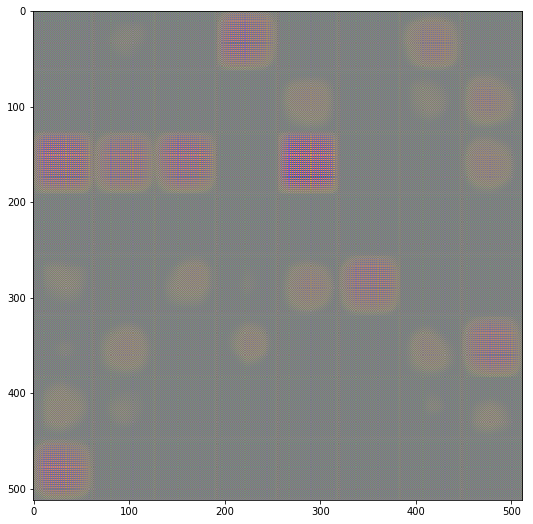

In [30]:
netD.eval(); netG.eval();
fake = netG(fixed_noise).data.cpu()
faked = np.clip(md.trn_ds.denorm(fake),0,1)

plt.figure(figsize=(9,9))
plt.imshow(gallery(faked, 8));

In [27]:
torch.save(netG.state_dict(), TMP_PATH/f'netG_{cyc}.h5')
torch.save(netD.state_dict(), TMP_PATH/f'netD_{cyc}.h5')